In [3]:
import torch
import torch.nn as nn
import pandas as pd
from torch.optim import AdamW
from transformers import RobertaModel
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForMaskedLM, pipeline
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA toolkit version:", torch.version.cuda)
print("Device name:", torch.cuda.get_device_name(0))

Torch version: 2.7.1+cu118
CUDA available: True
CUDA toolkit version: 11.8
Device name: NVIDIA GeForce RTX 3050 Laptop GPU


In [4]:
pipe = pipeline("fill-mask", model="NLPC-UOM/SinBERT-large")
tokenizer = AutoTokenizer.from_pretrained("NLPC-UOM/SinBERT-large")
model = AutoModelForMaskedLM.from_pretrained("NLPC-UOM/SinBERT-large")

Device set to use cuda:0


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [6]:
df = pd.read_csv('./processed/processed_dataset.csv')

# After loading df and before defining criterion
labels = df['label'].values
class_sample_count = np.array([np.sum(labels == t) for t in np.unique(labels)])
weight = 1. / class_sample_count

#converts numpy array of weights to torch tensor and move it to the same device as the model
class_weights = torch.tensor(weight, dtype=torch.float).to(device)

# Use in loss function
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer= AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

In [7]:
class_sample_count

array([502, 540, 504, 606, 507, 496])

## Creating the DataSet Class


the class wich represent the data.the dataloder will use this class to load the data one by one or in batches.it relies on 2 methods.

- `__len__`    - returns the length of the dataset
- `__getitem__` - returns the item at the given index
Also it has the constructor which takes the dataframe, tokenizer and max_length as input parameters.
- `__init__`- constructor to initialize the dataset with a dataframe, tokenizer, and maximum sequence length.
    - `self.text`,`self.label` - store the raw sinhala texts and labels from the dataframe.
    - `self.tokenizer` - stores the tokenizer object.
    - `self.max_length` - stores the maximum length of the input sequence.all the sentences will be padded or truncated to this length.

In [8]:
class SinhalaEmotionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        # Create label-to-index mapping
        self.label2idx = {label: idx for idx, label in enumerate(sorted(set(labels)))}
        self.labels = [self.label2idx[label] for label in labels]
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

## Dataloader

In [9]:
df_train,df_test=train_test_split(df,test_size=0.2,random_state=42,stratify=df['label'])#stratify is used to maintain the class distribution in the train and test sets(emotion percentages are same in both sets).

#Dataset and Dataloader
BATCH_SIZE = 16
# Instantiate the custom dataset for each split
train_dataset = SinhalaEmotionDataset(
    texts=df_train['text'].tolist(),
    labels=df_train['label'].tolist(),
    tokenizer=tokenizer
)

test_dataset = SinhalaEmotionDataset(
    texts=df_test['text'].tolist(),
    labels=df_test['label'].tolist(),
    tokenizer=tokenizer
)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)
# Set up the DataLoader for each split
train_data_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_data_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE
)

print("Data Loaders for training, validation, and testing are ready.")

Data Loaders for training, validation, and testing are ready.


## Building the Model Architecture


every pytorch model should inherit from `nn.Module` class. The model should have the following methods.
- `__init__` - constructor to initialize the model with a pre-trained BERT model and a CNN layer.
    - `self.bert` - stores the pre-trained BERT model.
    - `self.cnn` - stores the CNN layer.
    - `self.relu` - stores the ReLU activation function.
    - `self.pool` - stores the adaptive max pooling layer.

In [16]:
class SinbertCNN(nn.Module):
    """
    SinbertCNN combines a RoBERTa-based encoder with CNN layers for emotion classification.
    Args:
        num_labels (int): Number of output classes.
        embedding_dim (int): Dimensionality of SinBERT embeddings.
        num_filters (int): Number of filters per CNN layer.
        kernel_sizes (list): List of kernel sizes for CNN layers.
        dropout_rate (float): Dropout rate for regularization.
        pretrained_model_name (str): Name of the pretrained RoBERTa model.
    """
    def __init__(self, num_labels, embedding_dim=1024, num_filters=100, kernel_sizes=None, dropout_rate=0.5, pretrained_model_name="NLPC-UOM/SinBERT-large"):
        super(SinbertCNN, self).__init__()

        if kernel_sizes is None:
            kernel_sizes = [3, 4, 5]
        self.sinbert = RobertaModel.from_pretrained(pretrained_model_name)
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=embedding_dim,
                      out_channels=num_filters,
                      kernel_size=k)
            for k in kernel_sizes
        ])
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(num_filters * len(kernel_sizes), num_labels)

    def forward(self, input_ids, attention_mask):

        outputs = self.sinbert(input_ids=input_ids, attention_mask=attention_mask)
        embeddings = outputs.last_hidden_state
        x = embeddings.permute(0, 2, 1)
        conv_outputs = [torch.relu(conv(x)) for conv in self.convs]
        pooled_outputs = [torch.max(conv_output, dim=2)[0] for conv_output in conv_outputs]
        concatenated_output = torch.cat(pooled_outputs, dim=1)
        dropout_output = self.dropout(concatenated_output)
        logits = self.fc(dropout_output)
        return logits

## Training the Model

In [11]:
import torch

def train_model_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, device, epochs=10, patience=2):
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            optimizer.zero_grad()
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * input_ids.size(0)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).float().sum().item()
            total += labels.size(0)
        epoch_loss = running_loss / total
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        # Validation
        model.eval()
        val_running_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * input_ids.size(0)
                preds = torch.argmax(outputs, dim=1)
                val_correct += (preds == labels).float().sum().item()
                val_total += labels.size(0)
        val_loss = val_running_loss / val_total
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                model.load_state_dict(best_model_state)
                break

    return train_losses, train_accuracies, val_losses, val_accuracies

In [25]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def evaluate_metrics(model, data_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    acc = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro')
    return acc, precision, recall, f1


#### Hyper parameter Tuning

In [12]:
# Python
from transformers import AutoConfig

config = AutoConfig.from_pretrained("NLPC-UOM/SinBERT-large")
print("Hidden size:", config.hidden_size)  # Use this value for embedding_dim

Hidden size: 768


### tuning process

In [13]:
import itertools

# Define hyperparameter grid
param_grid = {
    'embedding_dim': [768],
    'num_filters': [50, 100],
    'kernel_sizes': [[3, 4, 5], [2, 3, 4, 5]],
    'dropout_rate': [0.2, 0.3],
}

all_combinations = list(itertools.product(
    param_grid['embedding_dim'],
    param_grid['num_filters'],
    param_grid['kernel_sizes'],
    param_grid['dropout_rate']
))

# Hyperparameter tuning loop with status bar
results = []
num_labels = len(df['label'].unique())

for emb_dim, num_filt, kernels, drop in tqdm(all_combinations, desc='Hyperparameter Tuning'):
    model = SinbertCNN(
        num_labels=num_labels,
        embedding_dim=emb_dim,
        num_filters=num_filt,
        kernel_sizes=kernels,
        dropout_rate=drop
    ).to(device)
    optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    train_model_with_early_stopping(
        model=model,
        train_loader=train_data_loader,
        val_loader=test_data_loader,
        criterion=criterion,
        optimizer=optimizer,
        device=device,
        epochs=10,      # Set higher epochs
        patience=2      # Early stopping patience
    )
    acc, precision, recall, f1 = evaluate_metrics(model, test_data_loader, device)
    results.append({
        'params': (emb_dim, num_filt, kernels, drop),
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    })

# After hyperparameter tuning loop
best_result = max(results, key=lambda x: x['accuracy'])
print('Best hyperparameters:', best_result['params'])
print('Best accuracy:', best_result['accuracy'])
print('Best precision:', best_result['precision'])
print('Best recall:', best_result['recall'])
print('Best F1:', best_result['f1'])

# Plot performance metrics for all hyperparameter combinations
accuracies = [r['accuracy'] for r in results]
precisions = [r['precision'] for r in results]
recalls = [r['recall'] for r in results]
f1s = [r['f1'] for r in results]
labels = [str(r['params']) for r in results]

plt.figure(figsize=(12, 8))
plt.plot(labels, accuracies, marker='o', label='Accuracy')
plt.plot(labels, precisions, marker='o', label='Precision')
plt.plot(labels, recalls, marker='o', label='Recall')
plt.plot(labels, f1s, marker='o', label='F1 Score')
plt.xticks(rotation=90)
plt.xlabel('Hyperparameter Combination')
plt.ylabel('Score')
plt.title('Performance Metrics Across Hyperparameter Combinations')
plt.legend()
plt.tight_layout()
plt.show()

Hyperparameter Tuning:   0%|          | 0/16 [00:00<?, ?it/s]

Some weights of RobertaModel were not initialized from the model checkpoint at NLPC-UOM/SinBERT-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10 - Train Loss: 1.5702, Train Acc: 0.3641, Val Loss: 1.1764, Val Acc: 0.5895
Epoch 2/10 - Train Loss: 0.9968, Train Acc: 0.6375, Val Loss: 0.9436, Val Acc: 0.6704
Epoch 3/10 - Train Loss: 0.6794, Train Acc: 0.7575, Val Loss: 0.8488, Val Acc: 0.7100
Epoch 4/10 - Train Loss: 0.4553, Train Acc: 0.8427, Val Loss: 0.8647, Val Acc: 0.7147
Epoch 5/10 - Train Loss: 0.3057, Train Acc: 0.8970, Val Loss: 0.9052, Val Acc: 0.7132
Early stopping at epoch 5


Some weights of RobertaModel were not initialized from the model checkpoint at NLPC-UOM/SinBERT-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10 - Train Loss: 1.7405, Train Acc: 0.3011, Val Loss: 1.3050, Val Acc: 0.5499
Epoch 2/10 - Train Loss: 1.1804, Train Acc: 0.5475, Val Loss: 0.9473, Val Acc: 0.6624
Epoch 3/10 - Train Loss: 0.8246, Train Acc: 0.7092, Val Loss: 0.8487, Val Acc: 0.6926
Epoch 4/10 - Train Loss: 0.5816, Train Acc: 0.8015, Val Loss: 0.8326, Val Acc: 0.7005
Epoch 5/10 - Train Loss: 0.3900, Train Acc: 0.8772, Val Loss: 0.8744, Val Acc: 0.7147
Epoch 6/10 - Train Loss: 0.2794, Train Acc: 0.9168, Val Loss: 0.9491, Val Acc: 0.6989
Early stopping at epoch 6


Some weights of RobertaModel were not initialized from the model checkpoint at NLPC-UOM/SinBERT-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10 - Train Loss: 1.5655, Train Acc: 0.3784, Val Loss: 1.1591, Val Acc: 0.5990
Epoch 2/10 - Train Loss: 0.9897, Train Acc: 0.6335, Val Loss: 0.8775, Val Acc: 0.6815
Epoch 3/10 - Train Loss: 0.6621, Train Acc: 0.7611, Val Loss: 0.8094, Val Acc: 0.7211
Epoch 4/10 - Train Loss: 0.4240, Train Acc: 0.8435, Val Loss: 0.8722, Val Acc: 0.7116
Epoch 5/10 - Train Loss: 0.2700, Train Acc: 0.9073, Val Loss: 0.9079, Val Acc: 0.7227
Early stopping at epoch 5


Some weights of RobertaModel were not initialized from the model checkpoint at NLPC-UOM/SinBERT-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10 - Train Loss: 1.7107, Train Acc: 0.2983, Val Loss: 1.2547, Val Acc: 0.5769
Epoch 2/10 - Train Loss: 1.1339, Train Acc: 0.5741, Val Loss: 0.9595, Val Acc: 0.6403
Epoch 3/10 - Train Loss: 0.7825, Train Acc: 0.7199, Val Loss: 0.8486, Val Acc: 0.6783
Epoch 4/10 - Train Loss: 0.5493, Train Acc: 0.8067, Val Loss: 0.8791, Val Acc: 0.6989
Epoch 5/10 - Train Loss: 0.3870, Train Acc: 0.8625, Val Loss: 0.8286, Val Acc: 0.7068
Epoch 6/10 - Train Loss: 0.2400, Train Acc: 0.9267, Val Loss: 0.9201, Val Acc: 0.7021
Epoch 7/10 - Train Loss: 0.1675, Train Acc: 0.9485, Val Loss: 0.9901, Val Acc: 0.6878
Early stopping at epoch 7


Some weights of RobertaModel were not initialized from the model checkpoint at NLPC-UOM/SinBERT-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10 - Train Loss: 1.5675, Train Acc: 0.3657, Val Loss: 1.1683, Val Acc: 0.6086
Epoch 2/10 - Train Loss: 0.9809, Train Acc: 0.6387, Val Loss: 0.9346, Val Acc: 0.6719
Epoch 3/10 - Train Loss: 0.6518, Train Acc: 0.7694, Val Loss: 0.8680, Val Acc: 0.6894
Epoch 4/10 - Train Loss: 0.4144, Train Acc: 0.8554, Val Loss: 0.8471, Val Acc: 0.7021
Epoch 5/10 - Train Loss: 0.2819, Train Acc: 0.9085, Val Loss: 0.8940, Val Acc: 0.7195
Epoch 6/10 - Train Loss: 0.1695, Train Acc: 0.9473, Val Loss: 0.8961, Val Acc: 0.7258
Early stopping at epoch 6


Some weights of RobertaModel were not initialized from the model checkpoint at NLPC-UOM/SinBERT-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10 - Train Loss: 1.6738, Train Acc: 0.3308, Val Loss: 1.2082, Val Acc: 0.5800
Epoch 2/10 - Train Loss: 1.0657, Train Acc: 0.6042, Val Loss: 0.9303, Val Acc: 0.6751
Epoch 3/10 - Train Loss: 0.7191, Train Acc: 0.7429, Val Loss: 0.8974, Val Acc: 0.6878
Epoch 4/10 - Train Loss: 0.5051, Train Acc: 0.8269, Val Loss: 0.9304, Val Acc: 0.6957
Epoch 5/10 - Train Loss: 0.3383, Train Acc: 0.8867, Val Loss: 0.8829, Val Acc: 0.7116
Epoch 6/10 - Train Loss: 0.2218, Train Acc: 0.9251, Val Loss: 0.9333, Val Acc: 0.7036
Epoch 7/10 - Train Loss: 0.1405, Train Acc: 0.9560, Val Loss: 1.0517, Val Acc: 0.7068
Early stopping at epoch 7


Some weights of RobertaModel were not initialized from the model checkpoint at NLPC-UOM/SinBERT-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10 - Train Loss: 1.5664, Train Acc: 0.3534, Val Loss: 1.1601, Val Acc: 0.6022
Epoch 2/10 - Train Loss: 0.9551, Train Acc: 0.6616, Val Loss: 0.9033, Val Acc: 0.6910
Epoch 3/10 - Train Loss: 0.6293, Train Acc: 0.7714, Val Loss: 0.8218, Val Acc: 0.7036
Epoch 4/10 - Train Loss: 0.3953, Train Acc: 0.8613, Val Loss: 0.8285, Val Acc: 0.7242
Epoch 5/10 - Train Loss: 0.2570, Train Acc: 0.9136, Val Loss: 0.9042, Val Acc: 0.7227
Early stopping at epoch 5


Some weights of RobertaModel were not initialized from the model checkpoint at NLPC-UOM/SinBERT-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10 - Train Loss: 1.7008, Train Acc: 0.3102, Val Loss: 1.2318, Val Acc: 0.5705
Epoch 2/10 - Train Loss: 1.0868, Train Acc: 0.5852, Val Loss: 0.9363, Val Acc: 0.6339
Epoch 3/10 - Train Loss: 0.7542, Train Acc: 0.7235, Val Loss: 0.8447, Val Acc: 0.7005
Epoch 4/10 - Train Loss: 0.5157, Train Acc: 0.8181, Val Loss: 0.8262, Val Acc: 0.7147
Epoch 5/10 - Train Loss: 0.3455, Train Acc: 0.8819, Val Loss: 0.8694, Val Acc: 0.7052
Epoch 6/10 - Train Loss: 0.2248, Train Acc: 0.9303, Val Loss: 0.9375, Val Acc: 0.6957
Early stopping at epoch 6


Some weights of RobertaModel were not initialized from the model checkpoint at NLPC-UOM/SinBERT-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RuntimeError: Given groups=1, weight of size [50, 1024, 3], expected input[16, 768, 128] to have 1024 channels, but got 768 channels instead

In [17]:
Res=results.copy()
Res

[{'params': (768, 50, [3, 4, 5], 0.3),
  'accuracy': 0.7131537242472267,
  'precision': 0.7235713543282547,
  'recall': 0.7131537242472267,
  'f1': 0.7133121646035033},
 {'params': (768, 50, [3, 4, 5], 0.5),
  'accuracy': 0.6988906497622821,
  'precision': 0.6942882143258774,
  'recall': 0.6988906497622821,
  'f1': 0.6942250859933127},
 {'params': (768, 50, [2, 3, 4, 5], 0.3),
  'accuracy': 0.722662440570523,
  'precision': 0.7220994579815199,
  'recall': 0.722662440570523,
  'f1': 0.7177954903041444},
 {'params': (768, 50, [2, 3, 4, 5], 0.5),
  'accuracy': 0.687797147385103,
  'precision': 0.6901508621364858,
  'recall': 0.687797147385103,
  'f1': 0.688593325803551},
 {'params': (768, 100, [3, 4, 5], 0.3),
  'accuracy': 0.7258320126782885,
  'precision': 0.724638598002239,
  'recall': 0.7258320126782885,
  'f1': 0.7244884682376055},
 {'params': (768, 100, [3, 4, 5], 0.5),
  'accuracy': 0.7068145800316957,
  'precision': 0.7138818756657997,
  'recall': 0.7068145800316957,
  'f1': 0.702

## Validation

#### 5 fold cross validation

In [26]:
from sklearn.model_selection import KFold

results_new=[]
import numpy as np
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

k_folds = 5
kfolds = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
labels = df['label'].values
texts = df['text'].tolist()
num_labels = 6
fold_results = []
train_losses_all = []
val_losses_all = []
all_labels_cv = []
all_preds_cv = []
final_results_after_cross_val=[]


for fold, (train_idx, val_idx) in enumerate(kfolds.split(texts, labels)):
    print(f"Fold {fold+1}/{k_folds}")
    train_texts = [texts[i] for i in train_idx]
    train_labels = [labels[i] for i in train_idx]
    val_texts = [texts[i] for i in val_idx]
    val_labels = [labels[i] for i in val_idx]

    train_dataset = SinhalaEmotionDataset(train_texts, train_labels, tokenizer)
    val_dataset = SinhalaEmotionDataset(val_texts, val_labels, tokenizer)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
    # Initialize a new model for each fold
    model = SinbertCNN(
        num_labels=6,
        embedding_dim=768,
        num_filters=100,
        kernel_sizes=[3,4,5],
        dropout_rate=0.3
    ).to(device)

    optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    criterion = nn.CrossEntropyLoss()  # Use class weights if needed

    train_losses, train_accuracies, val_losses, val_accuracies = train_model_with_early_stopping(
    model=model,
    train_loader=train_data_loader,
    val_loader=test_data_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    epochs=10,
    patience=2
)
    train_losses_all.append(train_losses)
    val_losses_all.append(val_losses)
    acc, precision, recall, f1 = evaluate_metrics(model, test_data_loader, device)

    model.eval()
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels_batch = batch['labels'].cpu().numpy()
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds_batch = torch.argmax(outputs, dim=1).cpu().numpy()
            all_labels_cv.extend(labels_batch)
            all_preds_cv.extend(preds_batch)


    final_results_after_cross_val.append({
    'fold': fold + 1,
    'accuracy': acc,
    'precision': precision,
    'recall': recall,
    'f1': f1
    })
     





Fold 1/5


Some weights of RobertaModel were not initialized from the model checkpoint at NLPC-UOM/SinBERT-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10 - Train Loss: 1.5808, Train Acc: 0.3613, Val Loss: 1.1611, Val Acc: 0.5769
Epoch 2/10 - Train Loss: 0.9737, Train Acc: 0.6403, Val Loss: 0.9030, Val Acc: 0.6593
Epoch 3/10 - Train Loss: 0.6624, Train Acc: 0.7563, Val Loss: 0.8370, Val Acc: 0.6957
Epoch 4/10 - Train Loss: 0.4301, Train Acc: 0.8498, Val Loss: 0.9041, Val Acc: 0.6846
Epoch 5/10 - Train Loss: 0.2800, Train Acc: 0.9105, Val Loss: 0.8986, Val Acc: 0.7290
Early stopping at epoch 5
Fold 2/5


Some weights of RobertaModel were not initialized from the model checkpoint at NLPC-UOM/SinBERT-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10 - Train Loss: 1.5462, Train Acc: 0.3780, Val Loss: 1.1403, Val Acc: 0.5848
Epoch 2/10 - Train Loss: 0.9435, Train Acc: 0.6521, Val Loss: 0.8769, Val Acc: 0.6878
Epoch 3/10 - Train Loss: 0.6378, Train Acc: 0.7666, Val Loss: 0.8122, Val Acc: 0.6894
Epoch 4/10 - Train Loss: 0.4138, Train Acc: 0.8526, Val Loss: 0.8170, Val Acc: 0.7116
Epoch 5/10 - Train Loss: 0.2745, Train Acc: 0.9109, Val Loss: 0.8735, Val Acc: 0.7147
Early stopping at epoch 5
Fold 3/5


Some weights of RobertaModel were not initialized from the model checkpoint at NLPC-UOM/SinBERT-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10 - Train Loss: 1.5316, Train Acc: 0.3871, Val Loss: 1.1354, Val Acc: 0.5864
Epoch 2/10 - Train Loss: 0.9358, Train Acc: 0.6537, Val Loss: 0.9073, Val Acc: 0.6609
Epoch 3/10 - Train Loss: 0.6284, Train Acc: 0.7702, Val Loss: 0.8436, Val Acc: 0.7005
Epoch 4/10 - Train Loss: 0.4187, Train Acc: 0.8518, Val Loss: 0.8748, Val Acc: 0.6989
Epoch 5/10 - Train Loss: 0.2720, Train Acc: 0.9093, Val Loss: 0.9576, Val Acc: 0.6926
Early stopping at epoch 5
Fold 4/5


Some weights of RobertaModel were not initialized from the model checkpoint at NLPC-UOM/SinBERT-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10 - Train Loss: 1.5322, Train Acc: 0.3811, Val Loss: 1.1241, Val Acc: 0.5864
Epoch 2/10 - Train Loss: 0.9303, Train Acc: 0.6533, Val Loss: 0.8606, Val Acc: 0.6878
Epoch 3/10 - Train Loss: 0.6180, Train Acc: 0.7781, Val Loss: 0.8230, Val Acc: 0.7211
Epoch 4/10 - Train Loss: 0.4096, Train Acc: 0.8590, Val Loss: 0.8423, Val Acc: 0.7227
Epoch 5/10 - Train Loss: 0.2652, Train Acc: 0.9132, Val Loss: 0.8686, Val Acc: 0.7100
Early stopping at epoch 5
Fold 5/5


Some weights of RobertaModel were not initialized from the model checkpoint at NLPC-UOM/SinBERT-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10 - Train Loss: 1.5364, Train Acc: 0.3823, Val Loss: 1.1601, Val Acc: 0.5895
Epoch 2/10 - Train Loss: 0.9465, Train Acc: 0.6529, Val Loss: 0.8866, Val Acc: 0.6815
Epoch 3/10 - Train Loss: 0.6307, Train Acc: 0.7789, Val Loss: 0.8521, Val Acc: 0.6989
Epoch 4/10 - Train Loss: 0.4016, Train Acc: 0.8597, Val Loss: 0.9041, Val Acc: 0.7116
Epoch 5/10 - Train Loss: 0.2535, Train Acc: 0.9176, Val Loss: 0.9559, Val Acc: 0.6957
Early stopping at epoch 5


In [18]:
    final_results_after_cross_val

[{'fold': 1,
  'accuracy': 0.7258320126782885,
  'precision': 0.7343185402621164,
  'recall': 0.7258320126782885,
  'f1': 0.7224630491003732},
 {'fold': 2,
  'accuracy': 0.7020602218700476,
  'precision': 0.7145551286302888,
  'recall': 0.7020602218700476,
  'f1': 0.6888029404758224},
 {'fold': 3,
  'accuracy': 0.6862123613312203,
  'precision': 0.6848815646548829,
  'recall': 0.6862123613312203,
  'f1': 0.6803917088867106},
 {'fold': 4,
  'accuracy': 0.7036450079239303,
  'precision': 0.7069524014910602,
  'recall': 0.7036450079239303,
  'f1': 0.7025836758023971},
 {'fold': 5,
  'accuracy': 0.7131537242472267,
  'precision': 0.7286529800389937,
  'recall': 0.7131537242472267,
  'f1': 0.7124809164095618}]

#### final evaluation metrics after cross validation

In [27]:
import numpy as np

# Extract metrics from each fold
accuracies = [fold['accuracy'] for fold in final_results_after_cross_val]
precisions = [fold['precision'] for fold in final_results_after_cross_val]
recalls = [fold['recall'] for fold in final_results_after_cross_val]
f1s = [fold['f1'] for fold in final_results_after_cross_val]

# Compute averages
avg_accuracy = np.mean(accuracies)
avg_precision = np.mean(precisions)
avg_recall = np.mean(recalls)
avg_f1 = np.mean(f1s)

print("Macro Performance")
print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average F1 Score: {avg_f1:.4f}")

Macro Performance
Average Accuracy: 0.7084
Average Precision: 0.7165
Average Recall: 0.7084
Average F1 Score: 0.7050


#### Training and Validation Loss Plots

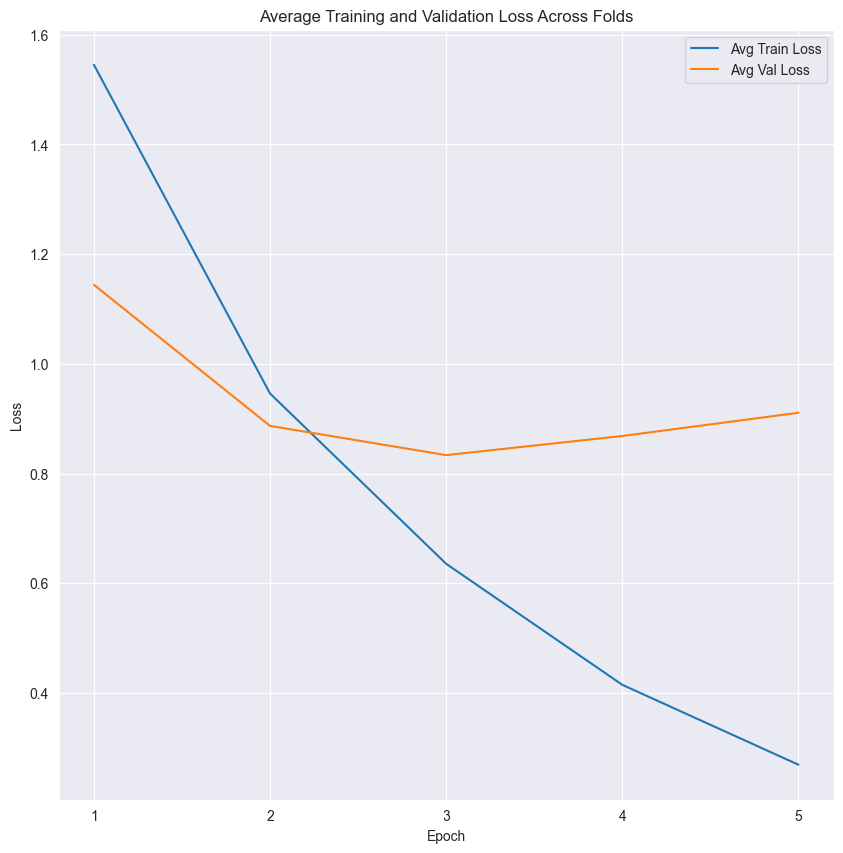

In [28]:


# Find the minimum length among all folds
min_len = min(len(l) for l in train_losses_all)

# Truncate all loss lists to min_len
train_losses_trimmed = [l[:min_len] for l in train_losses_all]
val_losses_trimmed = [l[:min_len] for l in val_losses_all]

# Now average
avg_train_loss = np.mean(train_losses_trimmed, axis=0)
avg_val_loss = np.mean(val_losses_trimmed, axis=0)

plt.figure(num=1,figsize=(10,10))
plt.plot(range(1, len(avg_train_loss)+1), avg_train_loss, label='Avg Train Loss')
plt.plot(range(1, len(avg_val_loss)+1), avg_val_loss, label='Avg Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Average Training and Validation Loss Across Folds')
plt.xticks(range(1, len(avg_train_loss)+1))
plt.show()

#### Global(Micro) Performance

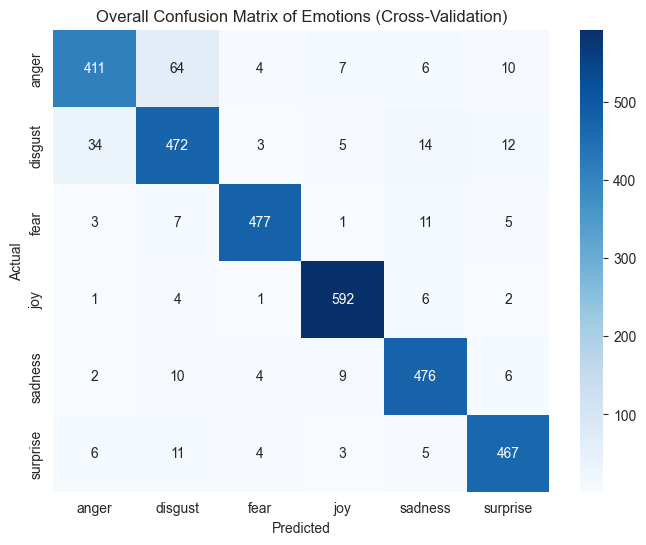

In [29]:
 #Compute overall confusion matrix
emotion_names = sorted(set(df['label'].values))
cm = confusion_matrix(all_labels_cv, all_preds_cv)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_names, yticklabels=emotion_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Overall Confusion Matrix of Emotions (Cross-Validation)')
plt.show()